In [52]:
import re
import json
from io import open
import numpy as np
import scipy as sp
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
with open("reviews_Movies_and_TV.json") as json_file:
    file_contents = json_file.readlines()
    
no_of_reviews = len(file_contents)

In [4]:
sentences = []
words = []
word_freq = {}
count = 0
MAX_SENTENCES = 40000
for i in range(no_of_reviews):
    review = json.loads(file_contents[i])['reviewText']
    review_sent = sent_tokenize(review.lower())
    review = re.sub(r'(?<=[a-zA-Z])[\.\?\!](?=[a-zA-Z])', '. ', review)
    for i,review in enumerate(review_sent):
        review_sent[i] = re.sub(r'[\.\?\!]', '', review)
    sentences += review_sent
    count += len(review_sent)
    for sent in review_sent:
        review_words = word_tokenize(sent)
        words += review_words
        for word in review_words:
            try: word_freq[word] += 1
            except KeyError: word_freq[word] = 1
    if count >= MAX_SENTENCES:
        break

In [5]:
json.loads(file_contents[0])['reviewText']

"This has some great tips as always and is helping me to complete my Good Eats collection.  I haven't tried any of the recipes yet, but I will soon.  Sometimes it's just lovely to let Alton entertain us."

In [6]:
sentences[40000-1]
sentence_list = sentences.copy()

In [7]:
freq_threshold = 3
words = [word if word_freq[word] > freq_threshold else '<unk>' for word in words]
words

['this',
 'has',
 'some',
 'great',
 'tips',
 'as',
 'always',
 'and',
 'is',
 'helping',
 'me',
 'to',
 'complete',
 'my',
 'good',
 'eats',
 'collection',
 'i',
 'have',
 "n't",
 'tried',
 'any',
 'of',
 'the',
 'recipes',
 'yet',
 ',',
 'but',
 'i',
 'will',
 'soon',
 'sometimes',
 'it',
 "'s",
 'just',
 'lovely',
 'to',
 'let',
 '<unk>',
 'entertain',
 'us',
 'this',
 'is',
 'a',
 'great',
 '<unk>',
 'guide',
 'i',
 'love',
 'how',
 '<unk>',
 "'s",
 'collections',
 'can',
 'break',
 'it',
 'down',
 'so',
 'baking',
 'is',
 "n't",
 'so',
 'mystical',
 'and',
 'scary',
 'i',
 'might',
 'even',
 'try',
 'some',
 'of',
 'these',
 'recipes',
 'some',
 'day',
 'i',
 'have',
 'to',
 'admit',
 'that',
 'i',
 'am',
 'a',
 'fan',
 'of',
 'giada',
 "'s",
 'cooking',
 'and',
 'i',
 'had',
 'great',
 'expectations',
 'when',
 'i',
 'ordered',
 'this',
 'set',
 'they',
 'were',
 'however',
 ',',
 'crushed',
 'while',
 'i',
 'still',
 'love',
 'giada',
 "'s",
 'cooking',
 ',',
 'this',
 'set',
 '

In [8]:
for i,sentence in enumerate(sentence_list):
    ws = word_tokenize(sentence)
    ws = [w if word_freq[w] > freq_threshold else '<unk>' for w in ws]
    sentences[i] = ws
                            
sentences[0]

['this',
 'has',
 'some',
 'great',
 'tips',
 'as',
 'always',
 'and',
 'is',
 'helping',
 'me',
 'to',
 'complete',
 'my',
 'good',
 'eats',
 'collection']

In [9]:
word_freq = {}
for word in words:
    try: word_freq[word] += 1
    except KeyError: word_freq[word] = 0
        
vocab = list(word_freq.keys())
word_freq['<unk>']

32550

In [10]:
index_to_word = {i: list(vocab)[i] for i in range(len(vocab)) }
word_to_index = {word: i for i, word in index_to_word.items()}

In [11]:
vocab_size = len(vocab)
matrix = sp.sparse.lil_matrix((vocab_size, vocab_size))
window_size = 3

for sentence in sentences:
    window = (sentence)[:window_size]
    for i, word in enumerate(sentence[:-window_size]):
        a = word_to_index[word]
        window = window[1:] + [sentence[i+window_size]]
        for co_occurer in window:
            b = word_to_index[co_occurer]
            try: matrix[a,b] += 1
            except KeyError: matrix[a,b] = 1
            except KeyError: matrix[a,b] = 1
            try: matrix[b,a] += 1
            except KeyError: matrix[b,a] = 1
            except KeyError: matrix[b,a] = 1
                
print(matrix[16,16])


0.0


In [12]:
matrix = matrix.toarray()

In [13]:
word_to_index['collection']

16

In [14]:
u, s, v = np.linalg.svd(matrix, hermitian=True)

In [15]:
u.shape

(8494, 8494)

In [63]:
embeddings = u[:,:300]

def get_top_words(wd):
    try: index = word_to_index[wd]
    except KeyError: index = word_to_index["<unk>"]
    tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)
    similarity_scores = cosine_similarity(embeddings[index].reshape(1, -1), embeddings) # reshape because otherwise pairwise
    top_indices = np.argsort(-similarity_scores)[0][:10] # returns list of list for some reason
    top_words = [index_to_word[i] for i in top_indices]
    
    top_embeddings = tsne_embeddings[top_indices]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], alpha=0.5)
    ax.scatter(top_embeddings[:, 0], top_embeddings[:, 1], marker='o', s=100, facecolors='none', edgecolors='r')
    for i, word in enumerate(top_words):
        ax.annotate(word, xy=top_embeddings[i], xytext=(10, 5), textcoords='offset points', ha='right', va='bottom', fontsize=10)
    ax.set_title(f'Top 10 Words Most Similar to "{wd}"')
    plt.show()

    return top_words
# ['water', 'spilled', 'dripping', 'sweat', 'gallons', 'guts', 'smell', 'gore', 'splattering', 'shed']

In [58]:
# from sklearn.decomposition import TruncatedSVD
# n_components = 300
# co_matrix = matrix.copy()
# svd = TruncatedSVD(n_components=n_components)
# word_embeddings = svd.fit_transform(co_matrix)
# word_index = word_to_index["water"]
# similarity_scores = cosine_similarity(word_embeddings[word_index].reshape(1, -1), word_embeddings)
# top_indices = np.argsort(-similarity_scores)[0][:10]
# top_words = [vocab[i] for i in top_indices]

# print(top_words)
# ['water', 'bread', 'caiaphas', 'dark', 'makeup', 'cultural', 'poles', 'flying', 'science', 'whippings']

/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


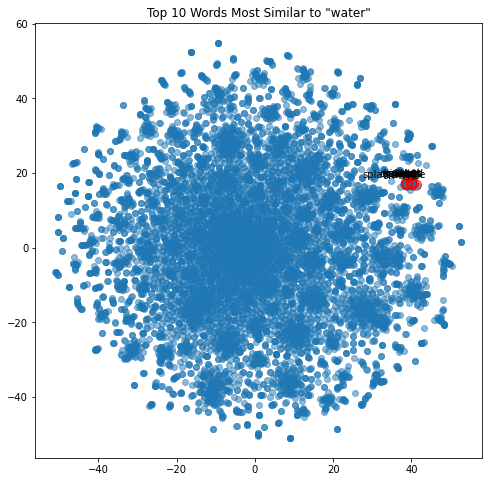

['water', 'spilled', 'dripping', 'sweat', 'gallons', 'guts', 'smell', 'gore', 'splattering', 'shed']


/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


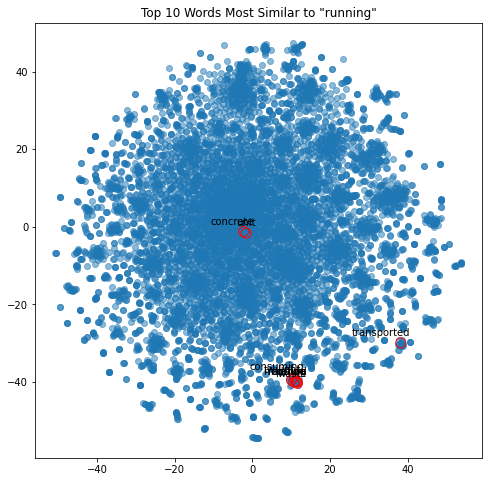

['running', 'machine', 'waste', 'run', 'consuming', 'period', 'twilight', 'transported', 'unit', 'concrete']


/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


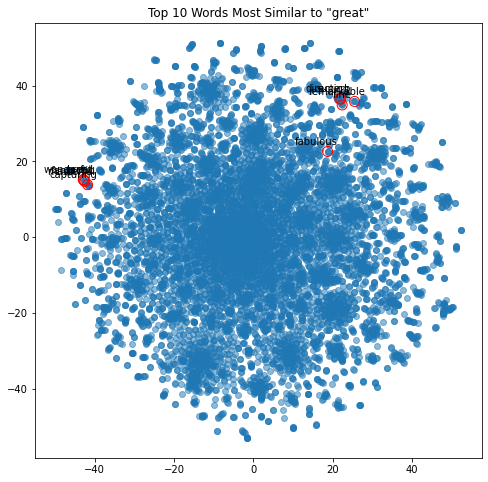

['great', 'wonderful', 'fantastic', 'fabulous', 'directing', 'superb', 'masterful', 'capturing', 'fine', 'remarkable']


/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


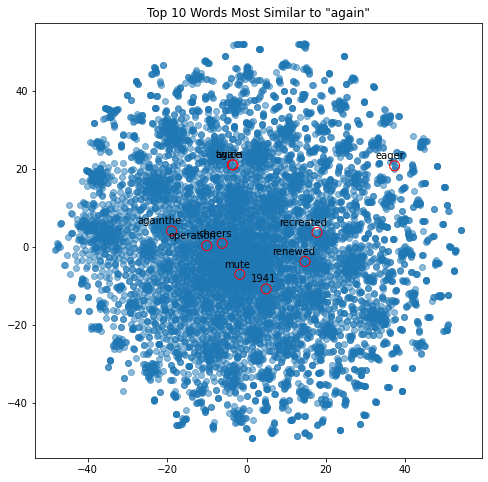

['again', 'recreated', 'cheers', '1941', 'againthe', 'mute', 'operation', 'renewed', 'twice', 'eager']


/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


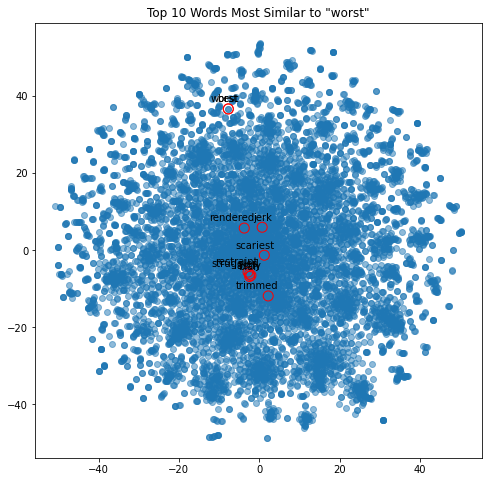

['worst', 'scariest', 'best', 'blah', 'lastly', 'rendered', 'trimmed', 'jerk', 'restraint', 'struggled']


In [64]:
print(get_top_words("water"))
print(get_top_words("running"))
print(get_top_words("great"))
print(get_top_words("again"))
print(get_top_words("worst"))

/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aryan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


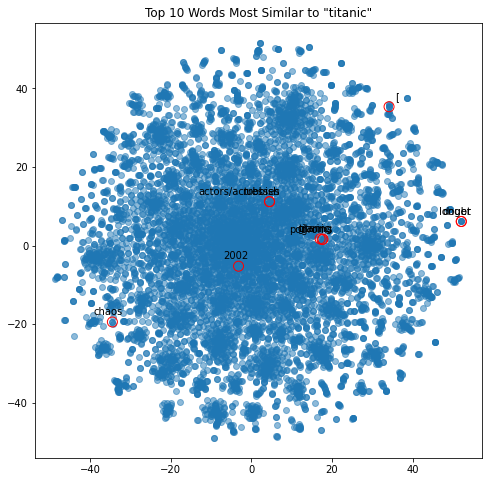

['titanic', 'longer', '[', 'actors/actresses', 'glaring', 'pogroms', '2002', 'chaos', 'rubbish', 'doubt']


In [66]:
print(get_top_words("titanic"))